In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams.update({'font.size': 22})

analysis = 'Status'

def format_fun(analysis,name):
    load = "../Reference Files/FOR RF - {analysis} - {name}.csv".format(analysis=analysis, name=name)
    fdata = pd.read_csv(load)

    # Record which samples were used in train vs test
    if name == 'Taxonomy':
        X_ = fdata.drop(analysis, axis=1)
        y = fdata[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=42)
        temp = pd.DataFrame({
        'Sample': X_train.Sample
        })
        tempname = "../Results/Supplementary Data/Random Forest/Samples used in training dataset.xlsx"
        writer=pd.ExcelWriter(tempname)
        temp.to_excel(writer,sheet_name="sheet")
        writer.close()

    # Record which samples were used in train vs test
    if name == 'Metabolites - Annotated Only':
        X_ = fdata.drop(analysis, axis=1)
        y = fdata[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.4, random_state=42)
        temp = pd.DataFrame({
        'Sample': X_train.Sample
        })
        tempname = "../Results/Supplementary Data/Random Forest/Samples used in training dataset - Metabolites.xlsx"
        writer=pd.ExcelWriter(tempname)
        temp.to_excel(writer,sheet_name="sheet")
        writer.close()

    fdata = fdata.drop('Sample',axis=1)

    le = LabelEncoder()
    fdata['Sex'] = le.fit_transform(fdata['Sex'])
    fdata[analysis] = le.fit_transform(fdata[analysis])
    fdata['smokeprev_or_before_pd'] = le.fit_transform(fdata['smokeprev_or_before_pd'])
    
    fdata_var = fdata[["Status",'Sex','bristol','logcoffeeperday','smokeprev_or_before_pd']] # Covariables only
    fdata_bac = fdata.drop('bristol',axis=1) # Bacteria
    fdata_bac = fdata_bac.drop('Sex',axis=1)
    fdata_bac = fdata_bac.drop('logcoffeeperday',axis=1)
    fdata_bac = fdata_bac.drop('smokeprev_or_before_pd',axis=1)

    ffiles = []
    ffiles.append(fdata_var)
    ffiles.append(fdata_bac)
    ffiles.append(fdata)

    ffilenames = ["Covar",name,"{name} & Covar".format(name=name)]
    results = [ffiles,ffilenames]
    return results

In [2]:
# Load Datasets

bac = format_fun(analysis, 'Taxonomy')
meta = format_fun(analysis, 'MetaCyc')
ko = format_fun(analysis, 'KO')
cog = format_fun(analysis, 'COG')
ec = format_fun(analysis, 'EC')
met = format_fun(analysis, 'Metabolites - Annotated Only')

# Functions

In [3]:
def plot_output (ftrain,ttrain,ftest,ttest,ratrain,ratest,ytest,ypred,dataset_name,folder):
    plt.plot(ftrain, ttrain, color='darkorange', lw=2, label='Train: %0.2f' % ratrain)
    plt.plot(ftest, ttest, color='blue', lw=2, label='Test: %0.2f' % ratest)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name}')
    plt.legend(loc='lower right')
    # Saving figure by changing parameter values
    if (dataset_name == 'Taxonomy' or dataset_name == 'MetaCyc' or dataset_name == 'Covar' or dataset_name == 'Taxonomy & Covar' or dataset_name == 'MetaCyc & Covar'):
        savename = "../Results/5. Random Forest/ROC Curve - {analysis} - {df}.png".format(analysis=analysis, df=dataset_name)
    else:
        savename = "../Results/Supplementary Figures/ROC Curve - {analysis} - {df}.png".format(analysis=analysis, df=dataset_name)
    
    plt.savefig(savename, format="png", bbox_inches="tight")
    plt.show()
    plt.close()

    conf_matrix = confusion_matrix(ytest, ypred)

    return conf_matrix

In [4]:
def run_rf(df,dataset_name,folder):
        print(f"Dataset: {dataset_name}")

        # Create test/train x,y
        X_ = df.drop(analysis, axis=1)
        y = df[analysis]
        X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=testsize, random_state=42)

        # Set up empty RF model
        rf_model = RandomForestClassifier(class_weight='balanced_subsample',random_state=42)

        # Hyperparameter tuning using Grid Search
        # Metabolites dataset has fewer samples, so reduce min_samples_split accordingly
        if (folder=='Metabolites'):
                mss = [30] # Too many metabolites, overfits otherwise
        else:
                mss = [21,23,25,27,31]
                
        param_grid = {
                'n_estimators': [50, 75, 100],
                'max_depth': [3,4,5,7,10],
                'min_samples_split': mss
        }
        grid_search = GridSearchCV(
                rf_model, param_grid, cv=5, scoring=auc_scorer, n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model found:
        best_params = grid_search.best_params_
        print(best_params)

        # RUN RF USING BEST PARAMS
        rfc=RandomForestClassifier(random_state=42, **grid_search.best_params_)
        rfc.fit(X_train, y_train)
        pred=rfc.predict(X_test)
        print("Accuracy for Random Forest on test dataset: ",accuracy_score(y_test,pred))

        # Plot ROC Curve and Confusion Matrix
        y_train_pred_prob = rfc.predict_proba(X_train)[:, 1]
        y_test_pred_prob = rfc.predict_proba(X_test)[:, 1]

        fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
        fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_test = auc(fpr_test, tpr_test)

        plots = plot_output(fpr_train,tpr_train,fpr_test,tpr_test,roc_auc_train,roc_auc_test,y_test,pred,dataset_name,folder)

        # Feature Importance
        feature_importances = rfc.feature_importances_

        importance_df = pd.DataFrame({
        'Feature': X_.columns,
        'Importance': feature_importances
        })

        importance_df = importance_df.sort_values(by='Importance', ascending=False)
        print(importance_df)

        results = [best_params,accuracy_score(y_test,pred),plots,importance_df]
        return results

# Covars Only

Dataset: Covar
{'max_depth': 5, 'min_samples_split': 21, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.7051282051282052


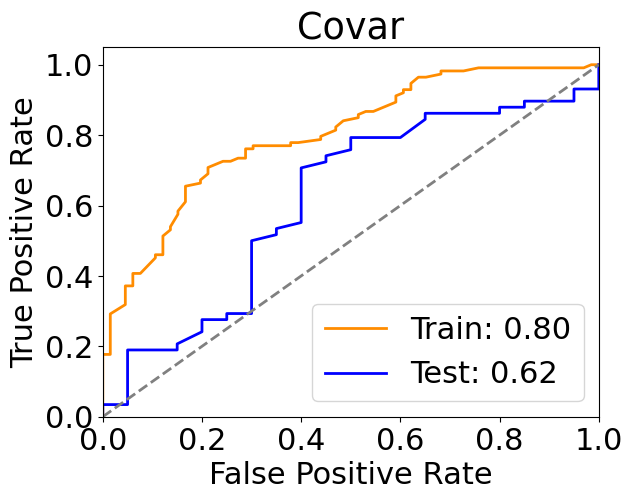

                  Feature  Importance
1                 bristol    0.444025
2         logcoffeeperday    0.306809
0                     Sex    0.208606
3  smokeprev_or_before_pd    0.040560


In [5]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = bac # Use first dataset to run covariable analysis (since covars are same for all datasets)
folder = 'Covar'

# Save fdata
params_cov = []
accuracy_cov = []
conf_cov = []
importance_cov = []

dataset = dataset_of_interest[0][0]
name = dataset_of_interest[1][0]
rf = run_rf(dataset,name,folder)
params_cov.append(rf[0])
accuracy_cov.append(rf[1])
conf_cov.append(rf[2])
importance_cov.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - Covars.xlsx".format(analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance_cov):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i]))
writer.close()

# Taxonomy

Dataset: Taxonomy
{'max_depth': 7, 'min_samples_split': 23, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.7051282051282052


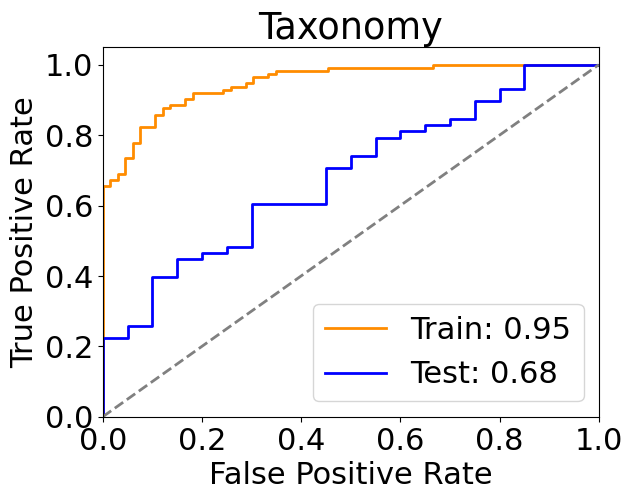

                              Feature  Importance
2  s__Ruthenibacterium_lactatiformans    0.223409
5           s__Alistipes_indistinctus    0.132422
7                s__Coprococcus_catus    0.131559
6                    s__Blautia_obeum    0.118099
1           s__Roseburia_intestinalis    0.115102
0     s__Faecalibacterium_prausnitzii    0.103280
3          s__Roseburia_inulinivorans    0.092971
4                 s__Blautia_wexlerae    0.083157
Dataset: Taxonomy & Covar
{'max_depth': 5, 'min_samples_split': 21, 'n_estimators': 75}
Accuracy for Random Forest on test dataset:  0.7307692307692307


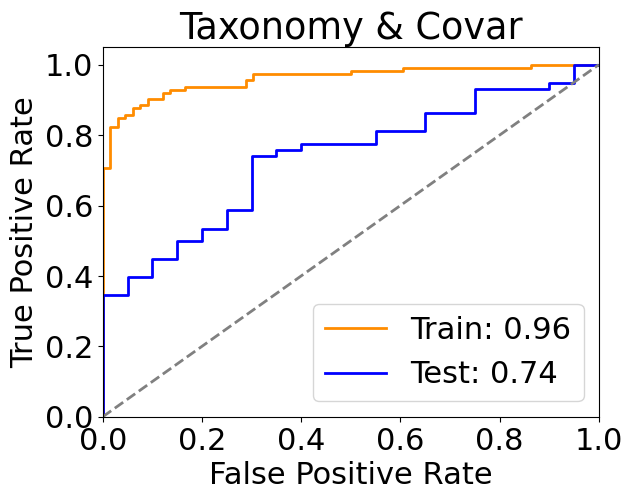

                               Feature  Importance
6   s__Ruthenibacterium_lactatiformans    0.160253
10                    s__Blautia_obeum    0.123580
11                s__Coprococcus_catus    0.119339
9            s__Alistipes_indistinctus    0.107021
4      s__Faecalibacterium_prausnitzii    0.104574
5            s__Roseburia_intestinalis    0.097395
7           s__Roseburia_inulinivorans    0.083023
8                  s__Blautia_wexlerae    0.080746
1                              bristol    0.058646
0                                  Sex    0.033286
2                      logcoffeeperday    0.019904
3               smokeprev_or_before_pd    0.012233


In [6]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = bac
folder = 'Taxonomy'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_b = params
accuracy_b = accuracy
conf_b = conf
importance_b = importance

# MetaCyc

Dataset: MetaCyc
{'max_depth': 10, 'min_samples_split': 21, 'n_estimators': 75}
Accuracy for Random Forest on test dataset:  0.717948717948718


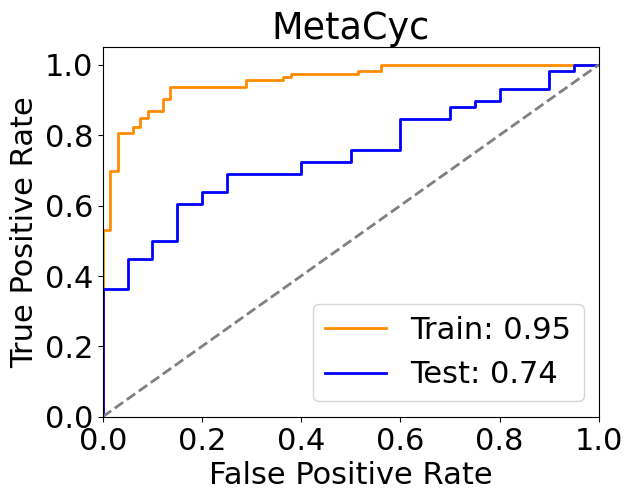

                                             Feature  Importance
0  PWY66-409: superpathway of purine nucleotide s...    0.223785
3  PWY-6471: peptidoglycan biosynthesis IV (Enter...    0.176861
1  PWY-7383: anaerobic energy metabolism (inverte...    0.133370
2                 PWY-5177: glutaryl-CoA degradation    0.127883
6               PWY-7242: D-fructuronate degradation    0.116741
4  GLUCUROCAT-PWY: superpathway of &beta;-D-glucu...    0.111558
5  GALACT-GLUCUROCAT-PWY: superpathway of hexuron...    0.109801
Dataset: MetaCyc & Covar
{'max_depth': 3, 'min_samples_split': 21, 'n_estimators': 75}
Accuracy for Random Forest on test dataset:  0.7307692307692307


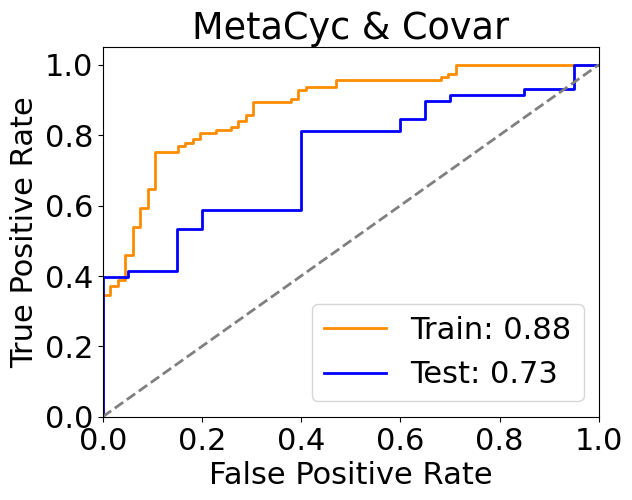

                                              Feature  Importance
7   PWY-6471: peptidoglycan biosynthesis IV (Enter...    0.212671
4   PWY66-409: superpathway of purine nucleotide s...    0.181540
5   PWY-7383: anaerobic energy metabolism (inverte...    0.111617
8   GLUCUROCAT-PWY: superpathway of &beta;-D-glucu...    0.102035
1                                             bristol    0.089284
10               PWY-7242: D-fructuronate degradation    0.083153
9   GALACT-GLUCUROCAT-PWY: superpathway of hexuron...    0.078723
6                  PWY-5177: glutaryl-CoA degradation    0.071832
2                                     logcoffeeperday    0.033371
0                                                 Sex    0.030492
3                              smokeprev_or_before_pd    0.005282


In [7]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = meta
folder = 'MetaCyc'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_m = params
accuracy_m = accuracy
conf_m = conf
importance_m = importance

# KO

Dataset: KO
{'max_depth': 10, 'min_samples_split': 21, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.8076923076923077


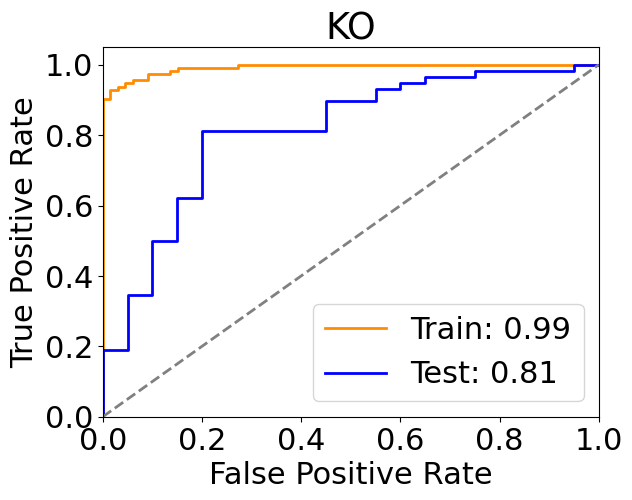

                                              Feature  Importance
42  K19299: aminoglycoside 3'-phosphotransferase I...    0.038194
27  K11754: dihydrofolate synthase / folylpolyglut...    0.037024
33        K02871: large subunit ribosomal protein L13    0.035213
36                    K09157: uncharacterized protein    0.033198
11   K00060: threonine 3-dehydrogenase [EC:1.1.1.103]    0.032012
..                                                ...         ...
57  K16786: energy-coupling factor transport syste...    0.007045
39  K03785: 3-dehydroquinate dehydratase I [EC:4.2...    0.006557
0   K02010: iron(III) transport system ATP-binding...    0.004841
2   K22293: GntR family transcriptional regulator,...    0.003516
58                   K08659: dipeptidase [EC:3.4.-.-]    0.002814

[62 rows x 2 columns]
Dataset: KO & Covar
{'max_depth': 4, 'min_samples_split': 25, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.8461538461538461


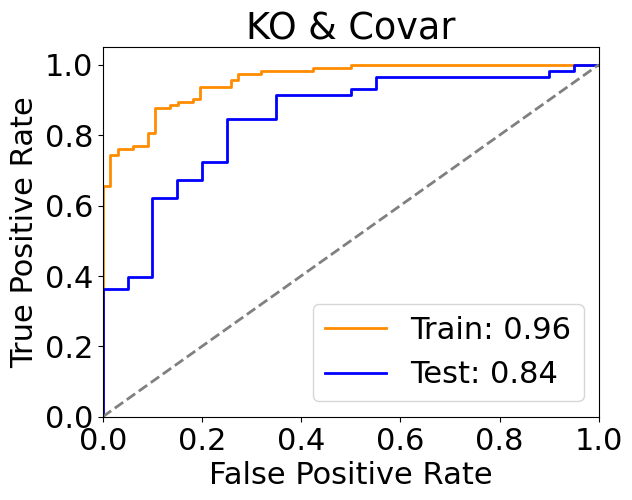

                                              Feature  Importance
31  K11754: dihydrofolate synthase / folylpolyglut...    0.044268
30                  K01937: CTP synthase [EC:6.3.4.2]    0.043353
26  K01693: imidazoleglycerol-phosphate dehydratas...    0.040338
37        K02871: large subunit ribosomal protein L13    0.034644
15   K00060: threonine 3-dehydrogenase [EC:1.1.1.103]    0.031969
..                                                ...         ...
43  K03785: 3-dehydroquinate dehydratase I [EC:4.2...    0.002819
1                                             bristol    0.001490
0                                                 Sex    0.000000
3                              smokeprev_or_before_pd    0.000000
33         K04771: serine protease Do [EC:3.4.21.107]    0.000000

[66 rows x 2 columns]


In [8]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = ko
folder = 'KO'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_k = params
accuracy_k = accuracy
conf_k = conf
importance_k = importance

# COG

Dataset: COG
{'max_depth': 7, 'min_samples_split': 25, 'n_estimators': 50}
Accuracy for Random Forest on test dataset:  0.8076923076923077


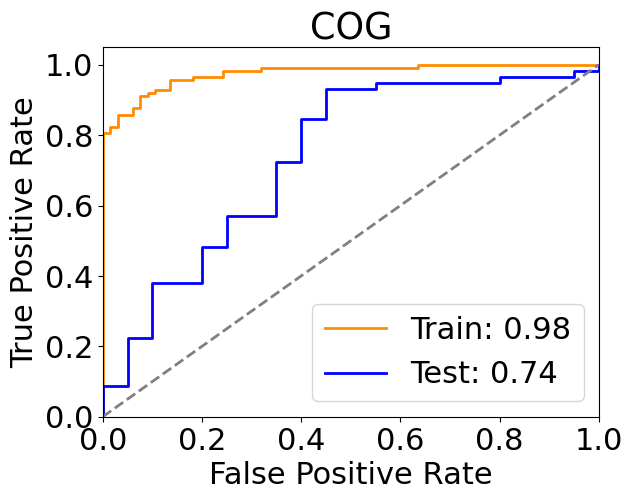

                                              Feature  Importance
16  COG0001: Glutamate-1-semialdehyde aminotransfe...    0.066475
1   COG1469: Converts GTP to 7,8-dihydroneo[...]n ...    0.060865
26                                  COG2819: esterase    0.057630
23  COG0718: Binds to DNA and alters its co[...]DN...    0.051594
9   COG0154: Allows the formation of correc[...]-G...    0.046866
0                                COG0671: PHOsphatase    0.043406
29                     COG1146: metal cluster binding    0.041282
2   COG0580: Channel that permits osmotical[...] i...    0.040568
17  COG0232: deoxyguanosinetriphosphate triphospho...    0.040559
14  COG2065: Also displays a weak uracil ph[...]ly...    0.038018
3                        COG1247: N-acetyltransferase    0.036152
7                        COG2214: DNAj domain protein    0.033572
18                                   COG4990: NO_NAME    0.032381
24       COG1546: competence damage-inducible protein    0.032304
27        

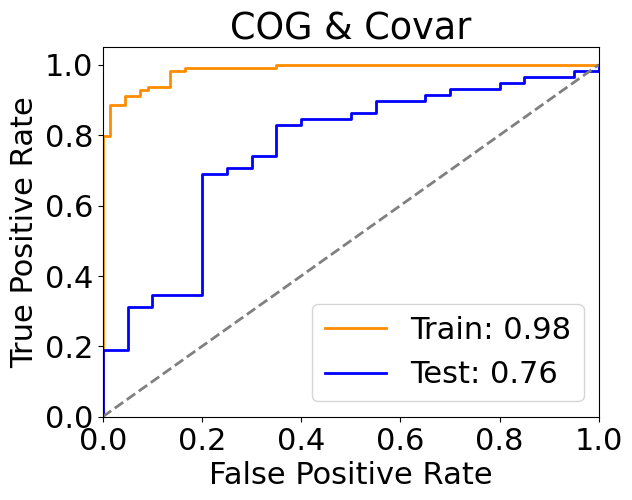

                                              Feature  Importance
33                     COG1146: metal cluster binding    0.044417
13  COG0154: Allows the formation of correc[...]-G...    0.044294
5   COG1469: Converts GTP to 7,8-dihydroneo[...]n ...    0.043634
31                 COG5523: integral membrane protein    0.043487
20  COG0001: Glutamate-1-semialdehyde aminotransfe...    0.039348
18  COG2065: Also displays a weak uracil ph[...]ly...    0.038606
27  COG0718: Binds to DNA and alters its co[...]DN...    0.038325
32                 COG2087: Adenosylcobinamide kinase    0.034842
8             COG0579: malate dehydrogenase (quinone)    0.032778
1                                             bristol    0.032462
4                                COG0671: PHOsphatase    0.031411
7                        COG1247: N-acetyltransferase    0.031156
22                                   COG4990: NO_NAME    0.030847
14          COG2206: Metal Dependent Phosphohydrolase    0.029181
34        

In [9]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = cog
folder = 'COG'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_c = params
accuracy_c = accuracy
conf_c = conf
importance_c = importance

# EC

Dataset: EC
{'max_depth': 4, 'min_samples_split': 23, 'n_estimators': 100}
Accuracy for Random Forest on test dataset:  0.7051282051282052


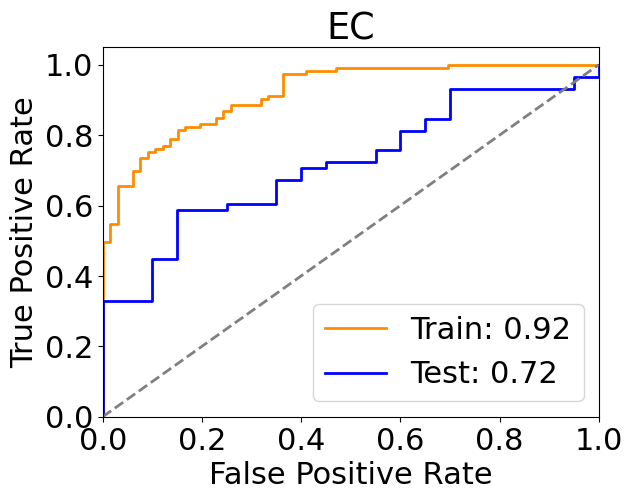

                                              Feature  Importance
11                     MANNONOXIDOREDUCT-RXN: NO_NAME    0.053868
5                                  RXN-12481: NO_NAME    0.052146
4                               4.1.1.32-RXN: NO_NAME    0.047703
7                     4OH2OXOGLUTARALDOL-RXN: NO_NAME    0.045410
18                     GLUC1PURIDYLTRANS-RXN: NO_NAME    0.039388
6                     ARGININE-DEIMINASE-RXN: NO_NAME    0.038973
35                       GALACTARDEHYDRA-RXN: NO_NAME    0.036581
12                                RXN8J2-140: NO_NAME    0.035538
3                                 DTMPKI-RXN: NO_NAME    0.034941
10              PYROGLUTAMYL-PEPTIDASE-I-RXN: NO_NAME    0.033507
0                                  RXN0-6481: NO_NAME    0.031869
29     RXN-12570: 3-hydroxyhexanoyl-CoA dehydrogenase    0.028616
38                            CHEBDEAMID-RXN: NO_NAME    0.026755
43             GLUCONATE-5-DEHYDROGENASE-RXN: NO_NAME    0.025996
16        

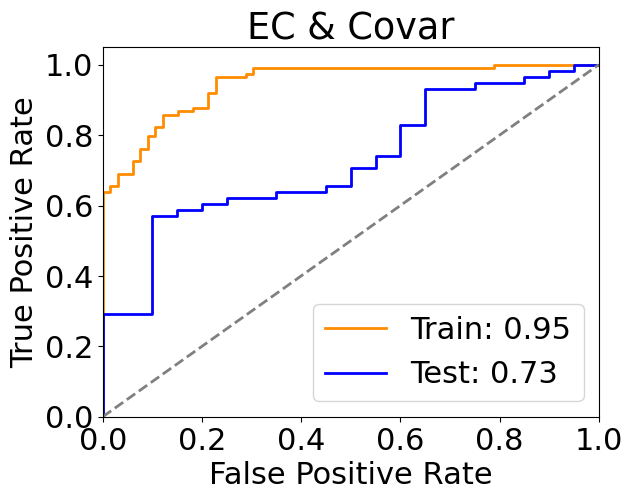

                                              Feature  Importance
22                     GLUC1PURIDYLTRANS-RXN: NO_NAME    0.042305
15                     MANNONOXIDOREDUCT-RXN: NO_NAME    0.040832
7                                 DTMPKI-RXN: NO_NAME    0.038139
11                    4OH2OXOGLUTARALDOL-RXN: NO_NAME    0.037157
14              PYROGLUTAMYL-PEPTIDASE-I-RXN: NO_NAME    0.032157
16                                RXN8J2-140: NO_NAME    0.032007
10                    ARGININE-DEIMINASE-RXN: NO_NAME    0.031955
38         PTAALT-RXN: phosphate propanoyltransferase    0.031930
8                               4.1.1.32-RXN: NO_NAME    0.031056
42                            CHEBDEAMID-RXN: NO_NAME    0.030420
9                                  RXN-12481: NO_NAME    0.029921
37                                 RXN-16133: NO_NAME    0.029620
47             GLUCONATE-5-DEHYDROGENASE-RXN: NO_NAME    0.029606
39                       GALACTARDEHYDRA-RXN: NO_NAME    0.027724
40        

In [10]:
# Set Parameters
testsize = 0.3
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = ec
folder = 'EC'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])

# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - {folder}.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(dataset_of_interest[1][i+1]))
writer.close()

params_e = params
accuracy_e = accuracy
conf_e = conf
importance_e = importance

# METABOLITES

Dataset: Metabolites - Annotated Only
{'max_depth': 3, 'min_samples_split': 30, 'n_estimators': 75}
Accuracy for Random Forest on test dataset:  0.4864864864864865


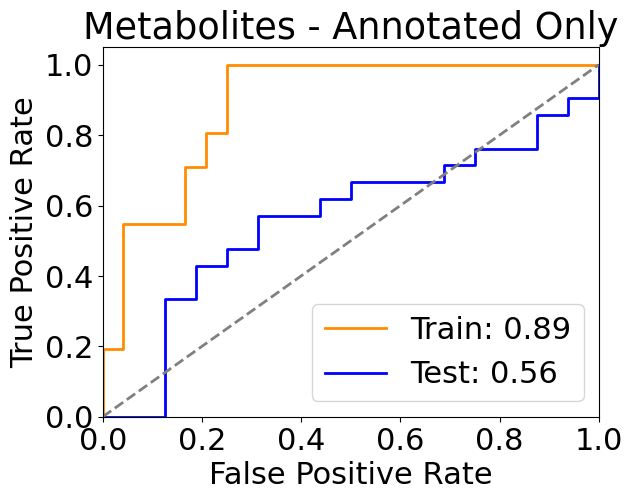

                               Feature  Importance
16               Sulfolithocholic acid    0.112804
13                  5-MTHP-L-glutamate    0.085283
11         25 carbon monoacylglyceride    0.084873
22                          L-Tyrosine    0.080000
18              32-carbon triglyceride    0.070250
12          Phenylacetylglutamine/AFMK    0.066667
14                            p-Cresol    0.060922
2          Unknown bile acid_355.26326    0.053333
20    Glycochenodeoxycholate-3-sulfate    0.051893
9          Unknown bile acid_391.28452    0.051768
15                    p-Cresol sulfate    0.040000
21                       Sedoheptulose    0.040000
19                 Protocatechuic acid    0.032713
3           Glycochenodeoxycholic acid    0.026667
5                Phenylacetylglutamine    0.026667
4                53 carbon cardiolipin    0.026004
10              32 carbon triglyceride    0.025470
0          Unknown bile acid_357.27896    0.016014
1          Unknown bile acid_37

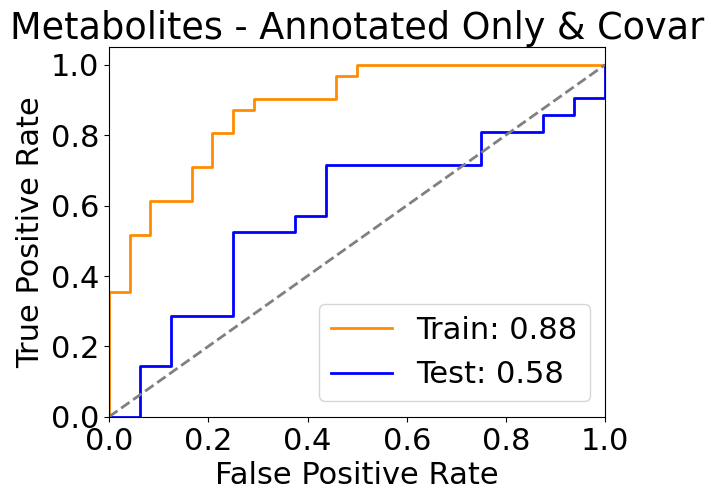

                               Feature  Importance
20               Sulfolithocholic acid    0.105194
6          Unknown bile acid_355.26326    0.085396
25                       Sedoheptulose    0.080000
19                    p-Cresol sulfate    0.068546
18                            p-Cresol    0.064768
4          Unknown bile acid_357.27896    0.060000
13         Unknown bile acid_391.28452    0.059038
21              36-carbon triglyceride    0.058892
16          Phenylacetylglutamine/AFMK    0.052282
15         25 carbon monoacylglyceride    0.044026
8                53 carbon cardiolipin    0.040000
17                  5-MTHP-L-glutamate    0.036657
12                         Cholic acid    0.032450
24    Glycochenodeoxycholate-3-sulfate    0.031454
9                Phenylacetylglutamine    0.030679
22              32-carbon triglyceride    0.029642
11  Deoxycholic acid glycine conjugate    0.029321
23                 Protocatechuic acid    0.028780
26                          L-T

In [11]:
# Set Parameters
testsize = 0.4
roc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
auc_scorer = 'accuracy'
scorer = roc_scorer
dataset_of_interest = met
folder = 'Metabolites'

# Save fdata
params = []
accuracy = []
conf = []
importance = []

# Start=1 to skip covars, already run
for i in range(1,3):
    dataset = dataset_of_interest[0][i]
    name = dataset_of_interest[1][i]
    rf = run_rf(dataset,name,folder)
    params.append(rf[0])
    accuracy.append(rf[1])
    conf.append(rf[2])
    importance.append(rf[3])


# Save importance values
name = "../Results/Supplementary Data/Random Forest/RF Importance Values - {analysis} - Metabolites Annot&Covar.xlsx".format(folder=folder,analysis=analysis)
writer=pd.ExcelWriter(name)

excelnames = ["Metabolites","Metabolites & Covar"]
for i, A in enumerate(importance):
    A.to_excel(writer,sheet_name="{0}".format(excelnames[i]))
writer.close()

params_met = params
accuracy_met = accuracy
conf_met = conf
importance_met= importance